In [14]:
from darts.models import TiDEModel
from darts.dataprocessing.transformers.scaler import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch

In [6]:
import sys
import os

# Go up two levels from notebook (Training/MLR) to project root
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to sys.path:", project_root)
# Ensure the model save directory exists
model_save_path = os.path.join(project_root, 'Models', 'Weights', 'MLR')
os.makedirs(model_save_path, exist_ok=True)  # Creates directory if it doesn't exist

Project root added to sys.path: c:\Users\James\COMP5530M-Group-Project-Inflation-Forecasting


Data loading

In [10]:
import pandas as pd
from sklearn import linear_model
from Training.Helper.dataPreprocessing import TRAIN_DATA_PATH_1990S, get_untransformed_exog
date_col = 'observation_date'

# Load and format training data (only using PCEPI)
train_df = pd.read_csv(TRAIN_DATA_PATH_1990S)
train_df = get_untransformed_exog(train_df)
# Convert the date column to datetime format
train_df[date_col] = pd.to_datetime(train_df[date_col], format='%m/%Y')

# Set the date column as the index
train_df.set_index(date_col, inplace=True)

In [11]:
from darts import TimeSeries
target_series = TimeSeries.from_series(train_df['fred_PCEPI'])

# Extract the exogenous variables (all columns except 'fred_PCEPI')
exogenous_variables = train_df.drop(columns=['fred_PCEPI'])
exogenous_series = TimeSeries.from_dataframe(exogenous_variables)

Basic model

In [ ]:
model = TiDEModel(input_chunk_length=24, output_chunk_length=6)

# Fit the model with the target series and exogenous variables
model.fit(series=target_series,past_covariates=exogenous_series)

In [ ]:
pred = model.predict(6)
pred.values()

This is terrible 

Split validation and training then scale

In [15]:
train , val = target_series.split_after(0.8)
train_exo , val_exo = exogenous_series.split_after(0.8)

In [16]:
targetScaler = Scaler()  # default uses sklearn's MinMaxScaler
scaled_target = targetScaler.fit_transform(train)
scaled_val = targetScaler.transform(val)


exoScaler = Scaler() 
scaled_train_exo = exoScaler.fit_transform(train_exo)
scaled_val_exo = exoScaler.transform(val_exo)

<Axes: xlabel='observation_date'>

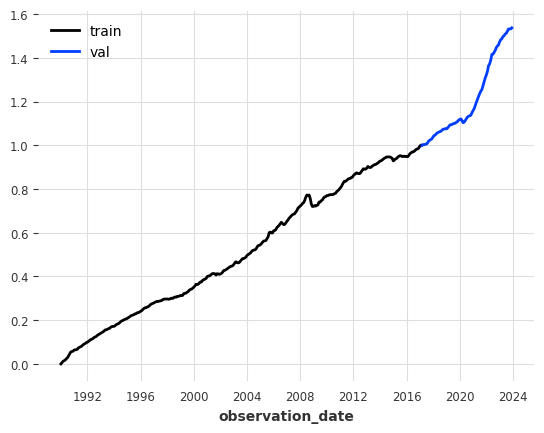

In [17]:
scaled_target.plot(label="train")
scaled_val.plot(label="val")

Basic model

In [ ]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=1e-3,
    mode='min'
)
lr_scheduler_kwargs = {
    "gamma": 0.999,
}
model = TiDEModel(
    input_chunk_length=48,
    output_chunk_length=12,
    pl_trainer_kwargs={
        "callbacks": [early_stopper]
    },
    optimizer_kwargs={
        "lr": 1e-3,
    },
    lr_scheduler_cls= torch.optim.lr_scheduler.ExponentialLR,
    lr_scheduler_kwargs = {
        "gamma": 0.999,
    },
    use_reversible_instance_norm = True
)

In [ ]:
model.fit(series=scaled_target,past_covariates=scaled_train_exo,val_series=scaled_val,val_past_covariates=scaled_val_exo,verbose=True)

Not that good so optuna test

In [ ]:
import optuna
from darts.metrics import mse
def objective(trial):
    # Suggest values for hyperparameters
    input_chunk_length = trial.suggest_int("input_chunk_length", 24, 60)
    num_encoder_layers = trial.suggest_int("num_encoder_layers", 1, 3)
    num_decoder_layers = trial.suggest_int("num_decoder_layers", 1, 3)
    hidden_size = trial.suggest_int("hidden_size", 64, 512)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    gamma = trial.suggest_float("gamma", 0.9, 1.0)

    # Define early stopping callback
    early_stopper = EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=1e-3,
        mode='min'
    )

    # Initialize the TiDEModel with suggested hyperparameters
    model = TiDEModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=12,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        hidden_size=hidden_size,
        dropout=dropout,
        optimizer_kwargs={"lr": lr},
        lr_scheduler_cls=torch.optim.lr_scheduler.ExponentialLR,
        lr_scheduler_kwargs={"gamma": gamma},
        pl_trainer_kwargs={"callbacks": [early_stopper]},
        log_tensorboard=True
    )

    # Fit the model
    model.fit(series=scaled_target,past_covariates=scaled_train_exo, val_series=scaled_val, val_past_covariates=scaled_val_exo)

    # Evaluate the model
    val_predictions = model.predict(n=12)
    transformed_predictions = targetScaler.inverse_transform(val_predictions)
    error = mse(val[:12], transformed_predictions)
    return error


In [ ]:
# Create an Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Retrieve the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

In [ ]:
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

Best params made into a model here

In [ ]:
    # Initialize the TiDEModel with suggested hyperparameters
        # Define early stopping callback
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=1e-3,
    mode='min'
)
model = TiDEModel(
    input_chunk_length=42,
    output_chunk_length=12,
    num_encoder_layers=3,
    num_decoder_layers=1,
    hidden_size=139,
    dropout=0.3836551817246969,
    optimizer_kwargs={"lr": 0.004682157117971461},
    lr_scheduler_cls=torch.optim.lr_scheduler.ExponentialLR,
    lr_scheduler_kwargs={"gamma": 0.9849317736277855},
    pl_trainer_kwargs={"callbacks": [early_stopper]},
    log_tensorboard=True
)

    # Fit the model
model.fit(series=scaled_target,past_covariates=scaled_train_exo, val_series=scaled_val, val_past_covariates=scaled_val_exo)



In [ ]:
    # Evaluate the model
val_predictions = model.predict(n=12)
transformed_predictions = targetScaler.inverse_transform(val_predictions)
error = mse(val[:12], transformed_predictions)
print(transformed_predictions)
print(val[:12])

In [1]:
model.save("tide.pkl")


NameError: name 'model' is not defined

Go from here if wanting to load model

In [18]:
from darts.models import TiDEModel

# Load the model from the file
model = TiDEModel.load("tide.pkl")

In [19]:
scaled_total = targetScaler.fit_transform(target_series)

scaled_total_exo = exoScaler.fit_transform(exogenous_series)

pred = model.predict(12,series=scaled_total,past_covariates=scaled_total_exo)
finalout = targetScaler.inverse_transform(pred)
print(finalout)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-04-01 02:13:09,971 - WARNING - From c:\Users\James\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

<TimeSeries (DataArray) (observation_date: 12, component: 1, sample: 1)> Size: 96B
array([[[116.73495471]],

       [[117.13901105]],

       [[117.88024489]],

       [[117.52597737]],

       [[115.8634181 ]],

       [[118.53772036]],

       [[121.98608713]],

       [[121.41109023]],

       [[119.57083275]],

       [[119.28455808]],

       [[116.55890225]],

       [[120.89217513]]])
Coordinates:
  * observation_date  (observation_date) datetime64[ns] 96B 2024-01-01 ... 20...
  * component         (component) object 8B 'fred_PCEPI'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None


In [21]:
import numpy as np
temp = finalout.to_dataframe()
flattend = temp.to_numpy().flatten().tolist()
np.save(f"..\\..\\Predictions\\Tide.npy",flattend)